## CIFAR 10

In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [19]:
from fastai.conv_learner import *
PATH = "/root/data/cifar10"
os.makedirs(PATH,exist_ok=True)

### Restructure cifar data to folder classes

In [25]:
# import os
# import glob

# TRN = os.path.join(PATH, 'train')
# TST = os.path.join(PATH, 'test')

# for dirchange in [TRN, TST]:
#     os.chdir(dirchange)
#     files = glob.glob("*.png")
#     for file in files:
#         i = file.find('_')+1
#         name = file[i:-4]
#         os.makedirs(name, exist_ok=True)
#         os.rename(file, name+'/'+file)

In [26]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [27]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [28]:
bs=256

### Look at data

In [30]:
data = get_data(32,4)

In [39]:
x,y=next(iter(data.trn_dl))

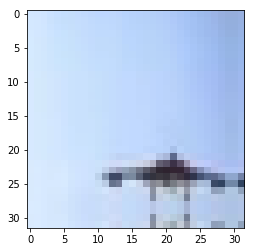

In [40]:
plt.imshow(data.trn_ds.denorm(x)[0]);

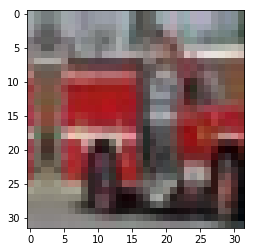

In [41]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

In [42]:
data = get_data(32,bs)

In [43]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [44]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [45]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [46]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [47]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [48]:
learn.lr_find()

 76%|███████▌  | 148/196 [00:11<00:03, 12.49it/s, loss=10.9]

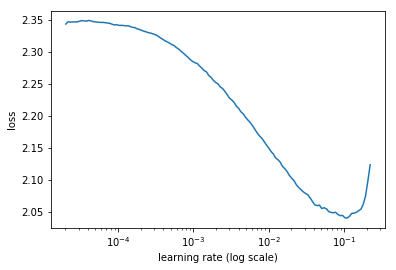

In [49]:
learn.sched.plot()

In [50]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.756861   1.64       0.4287    
    1      1.677969   1.570697   0.4467                     
CPU times: user 44.4 s, sys: 19 s, total: 1min 3s
Wall time: 34.7 s


[array([1.5707]), 0.4467]

In [51]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.614716   1.516142   0.4707    
    1      1.583611   1.496981   0.4786                     
CPU times: user 44.5 s, sys: 19.2 s, total: 1min 3s
Wall time: 34.8 s


[array([1.49698]), 0.4786]

## CNN

In [52]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2) 
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

`stride > 1` has similar effect to max pooling and is the more common way this is done now days. see 1:17 in video

Adaptive MaxPooling

2x2 adaptive maxpool is the same thing as doing a 14x14

Always make the penultimate layer a 1x1 adaptive MaxPool (find single largest cell and use that) (1x1 x number of features tensor). This is the 1x1x80 below.

`learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)` the 10 here is the number of classes to predict, size c above

Fully Connected Convolutional: Every layer is fully convolutional except the very last



In [53]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [54]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [74]:
learn.lr_find(end_lr=100)

epoch      trn_loss   val_loss   accuracy                    
    0      1.155234   1.793458   0.3819    


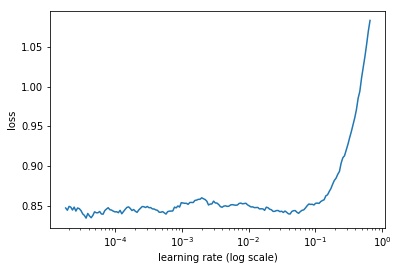

In [75]:
learn.sched.plot()

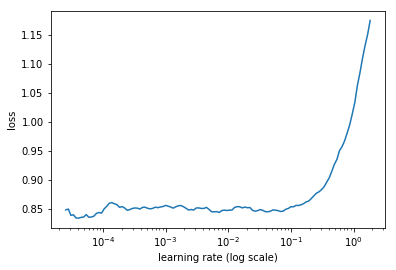

In [73]:
learn.sched.plot() # 1000

In [57]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.725223   1.568197   0.4336    
    1      1.539013   1.510739   0.4604                     
CPU times: user 45.6 s, sys: 18.8 s, total: 1min 4s
Wall time: 35.3 s


[array([1.51074]), 0.4604]

In [58]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.517782   1.437426   0.4786    
    1      1.369143   1.310549   0.5215                     
    2      1.308363   1.246469   0.5496                     
    3      1.265958   1.203938   0.5643                     
CPU times: user 1min 31s, sys: 38.7 s, total: 2min 10s
Wall time: 1min 10s


[array([1.20394]), 0.5643]

## Refactored

In [59]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [60]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [61]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [62]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [63]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.699422   1.63953    0.3974    
    1      1.527047   1.554772   0.4376                     
CPU times: user 45.5 s, sys: 18.8 s, total: 1min 4s
Wall time: 35 s


[array([1.55477]), 0.4376]

In [64]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.693892   1.613321   0.4109    
    1      1.468      1.397318   0.4935                     
CPU times: user 45.9 s, sys: 19.5 s, total: 1min 5s
Wall time: 35.6 s


[array([1.39732]), 0.4935]

## BatchNorm

BatchNorm is awesome (couple years old) because it makes deeper networks more easily trained. Jeremy found the above CNN stopped performing well after adding another layer, so this prompted him to show off BatchNorm below. BatchNorm is almost always used because it prevents weight matrices to cause activations to stay in a reasonable size.

In [65]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [66]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [67]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [68]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [69]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.506713   1.34153    0.5107    
    1      1.284618   1.163949   0.5838                     
CPU times: user 48.1 s, sys: 20 s, total: 1min 8s
Wall time: 36.5 s


[array([1.16395]), 0.5838]

In [70]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.152337   1.051918   0.6264    
    1      1.037538   0.931091   0.6717                     
    2      0.963457   0.895012   0.6866                      
    3      0.907419   0.851055   0.7015                      
CPU times: user 1min 38s, sys: 39.4 s, total: 2min 18s
Wall time: 1min 13s


[array([0.85105]), 0.7015]

## Deep BatchNorm

In [76]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [77]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [78]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.486638   1.35619    0.5107    
    1      1.292131   1.180464   0.5709                     
CPU times: user 51.5 s, sys: 19.9 s, total: 1min 11s
Wall time: 38.5 s


[array([1.18046]), 0.5709]

In [79]:
%time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.093678   1.0259     0.633     
    1      1.013147   1.013674   0.6443                     
CPU times: user 53.6 s, sys: 20.8 s, total: 1min 14s
Wall time: 39.9 s


[array([1.01367]), 0.6443]

## Resnet

In [82]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [83]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [84]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [85]:
wd=1e-5

In [86]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.591312   1.455793   0.4754    
    1      1.352085   1.252203   0.5549                     
CPU times: user 54.7 s, sys: 19.9 s, total: 1min 14s
Wall time: 42.5 s


[array([1.2522]), 0.5549]

In [87]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.162244   1.101261   0.6057    
    1      1.106096   1.026961   0.6349                     
    2      0.980864   0.954241   0.6589                      
    3      1.008413   1.000484   0.6441                     
    4      0.91289    0.867245   0.6927                      
    5      0.83004    0.831792   0.7098                      
    6      0.780823   0.803473   0.7198                      
CPU times: user 3min 13s, sys: 1min 10s, total: 4min 24s
Wall time: 2min 29s


[array([0.80347]), 0.7198]

In [88]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.876607   0.911236   0.6911    
    1      0.792323   0.82064    0.7178                      
    2      0.7118     0.721131   0.7524                      
    3      0.676084   0.712846   0.7555                      
    4      0.78134    0.820105   0.7193                      
    5      0.696041   0.696317   0.7602                      
    6      0.625139   0.671588   0.7662                      
    7      0.583926   0.654326   0.7718                      
    8      0.69171    0.736081   0.7457                      
    9      0.63324    0.695411   0.7647                      
    10     0.561503   0.667361   0.7752                      
    11     0.519312   0.623464   0.7898                      
    12     0.628453   0.70492    0.7669                      
    13     0.575002   0.640029   0.7804                      
    14     0.503695   0.611972   0.7963                      
    15     0.467334   0.60

[array([0.57722]), 0.8146]

Jeremy's output above:

A Jupyter Widget
[ 0.       0.8307   0.83635  0.7126 ]                        
[ 1.       0.74295  0.73682  0.74189]                        
[ 2.       0.66492  0.69554  0.75996]                        
[ 3.       0.62392  0.67166  0.7625 ]                        
[ 4.       0.73479  0.80425  0.72861]                        
[ 5.       0.65423  0.68876  0.76318]                        
[ 6.       0.58608  0.64105  0.77783]                        
[ 7.       0.55738  0.62641  0.78721]                        
[ 8.       0.66163  0.74154  0.7501 ]                        
[ 9.       0.59444  0.64253  0.78106]                        
[ 10.        0.53      0.61772   0.79385]                    
[ 11.        0.49747   0.65968   0.77832]                    
[ 12.        0.59463   0.67915   0.77422]                    
[ 13.        0.55023   0.65815   0.78106]                    
[ 14.        0.48959   0.59035   0.80273]                    
[ 15.        0.4459    0.61823   0.79336]                    
[ 16.        0.55848   0.64115   0.78018]                    
[ 17.        0.50268   0.61795   0.79541]                    
[ 18.        0.45084   0.57577   0.80654]                    
[ 19.        0.40726   0.5708    0.80947]                    
[ 20.        0.51177   0.66771   0.78232]                    
[ 21.        0.46516   0.6116    0.79932]                    
[ 22.        0.40966   0.56865   0.81172]                    
[ 23.        0.3852    0.58161   0.80967]                    
[ 24.        0.48268   0.59944   0.79551]                    
[ 25.        0.43282   0.56429   0.81182]                    
[ 26.        0.37634   0.54724   0.81797]                    
[ 27.        0.34953   0.54169   0.82129]                    
[ 28.        0.46053   0.58128   0.80342]                    
[ 29.        0.4041    0.55185   0.82295]                    
[ 30.        0.3599    0.53953   0.82861]                    
[ 31.        0.32937   0.55605   0.82227]                    

CPU times: user 22min 52s, sys: 8min 58s, total: 31min 51s
Wall time: 16min 38s

## Resnet 2

In [90]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [91]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [92]:
wd=1e-6

In [93]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.769607   1.59593    0.4267    
    1      1.500386   1.804911   0.5026                     
CPU times: user 57.2 s, sys: 20.7 s, total: 1min 17s
Wall time: 45.1 s


[array([1.80491]), 0.5026]

In [94]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.216522   1.105228   0.6134    
    1      1.236677   1.103995   0.6065                     
    2      1.016181   0.989331   0.6591                     
    3      1.111194   1.042041   0.6456                     
    4      0.963685   0.890906   0.6856                      
    5      0.855668   0.828258   0.7068                      
    6      0.798633   0.794434   0.7211                      
CPU times: user 3min 18s, sys: 1min 11s, total: 4min 30s
Wall time: 2min 36s


[array([0.79443]), 0.7211]

In [95]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.943362   0.860337   0.7007    
    1      0.819887   0.803284   0.7194                      
    2      0.728724   0.703143   0.7486                      
    3      0.6801     0.705485   0.7539                      
    4      0.804161   0.836061   0.7156                      
    5      0.717921   0.70782    0.7565                      
    6      0.630766   0.649992   0.773                       
    7      0.579766   0.63149    0.7834                      
    8      0.706709   0.721424   0.7487                      
    9      0.641984   0.638591   0.7763                      
    10     0.569617   0.590788   0.7955                      
    11     0.519701   0.580816   0.798                       
    12     0.639703   0.640605   0.7801                      
    13     0.575274   0.597617   0.7965                      
    14     0.518622   0.610805   0.7931                      
    15     0.471425   0.57

[array([0.52107]), 0.8293]

Jeremy run above:

A Jupyter Widget

[ 0.       0.92043  0.93876  0.67685]                        
[ 1.       0.8359   0.81156  0.72168]                        
[ 2.       0.73084  0.72091  0.74463]                        
[ 3.       0.68688  0.71326  0.74824]                        
[ 4.       0.81046  0.79485  0.72354]                        
[ 5.       0.72155  0.68833  0.76006]                        
[ 6.       0.63801  0.68419  0.76855]                        
[ 7.       0.59678  0.64972  0.77363]                        
[ 8.       0.71126  0.78098  0.73828]                        
[ 9.       0.63549  0.65685  0.7708 ]                        
[ 10.        0.56837   0.63656   0.78057]                    
[ 11.        0.52093   0.59159   0.79629]                    
[ 12.        0.66463   0.69927   0.76357]                    
[ 13.        0.58121   0.64529   0.77871]                    
[ 14.        0.52346   0.5751    0.80293]                    
[ 15.        0.47279   0.55094   0.80498]                    
[ 16.        0.59857   0.64519   0.77559]                    
[ 17.        0.54384   0.68057   0.77676]                    
[ 18.        0.48369   0.5821    0.80273]                    
[ 19.        0.43456   0.54708   0.81182]                    
[ 20.        0.54963   0.65753   0.78203]                    
[ 21.        0.49259   0.55957   0.80791]                    
[ 22.        0.43646   0.55221   0.81309]                    
[ 23.        0.39269   0.55158   0.81426]                    
[ 24.        0.51039   0.61335   0.7998 ]                    
[ 25.        0.4667    0.56516   0.80869]                    
[ 26.        0.39469   0.5823    0.81299]                    
[ 27.        0.36389   0.51266   0.82764]                    
[ 28.        0.48962   0.55353   0.81201]                    
[ 29.        0.4328    0.55394   0.81328]                    
[ 30.        0.37081   0.50348   0.83359]                    
[ 31.        0.34045   0.52052   0.82949]                    

CPU times: user 23min 30s, sys: 9min 1s, total: 32min 32s
Wall time: 17min 16s

In [96]:
learn.save('tmp3')

In [97]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [99]:
metrics.log_loss(y,preds), accuracy(preds,y)

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


### End